In [1]:
import os
import shutil

import numpy as np
import pandas as pd

import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = "/home/carlos/Documentos/datasets/severstal"

x_train_dir = os.path.join(DATA_DIR,"train_images")
x_test_dir = os.path.join(DATA_DIR,"test_images")

# Creo este directorio para guardar las imágenes segmentadas a partir de los encoded pixels
y_train_dir = os.path.join(DATA_DIR,"train_images_label")

# Creo este directorio para guardar solo las imágenes que tienen defectos, esto es para corroborar el OHE
x_train_aux_dir = os.path.join(DATA_DIR,"train_images_aux")

print("Cantidad de imágenes en Train\t:", len(os.listdir(x_train_dir)))
print("Cantidad de imágenes en Test\t:", len(os.listdir(x_test_dir)))

Cantidad de imágenes en Train	: 12568
Cantidad de imágenes en Test	: 5506


In [12]:
df_train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
print("Cantidad de imágenes con defecto (train):", df_train.shape[0])
df_train.head()

Cantidad de imágenes con defecto (train): 7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [13]:
df_train['fname'], df_train['cls'] = df_train['ImageId'], df_train['ClassId']
df_train['cls'] = df_train['cls'].astype(int)

df_train = df_train.pivot(index = 'fname', columns = 'cls', values = 'EncodedPixels')
df_train['defects'] = df_train.count(axis = 1)

df_train.head()

cls,1,2,3,4,defects
fname,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1


Función rle_to_mask para pasar a pixel y segmentar de acuerdo al color asignado a la clase

In [15]:
def rle_to_mask(row_id):

    palette = np.array([[0, 0, 0],         # black
                        [255, 0, 0],       # red
                        [0, 255, 0],       # green
                        [0, 0, 255],       # blue
                        [255, 255, 255]])  # white

    fname = df_train.iloc[row_id].name
    labels = df_train.iloc[row_id][:4]
    mask = np.zeros((256, 1600, 4), dtype = np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask_aux = np.zeros(256 * 1600, dtype = np.uint8)
            for pos, le in zip(positions, length):
                mask_aux[pos:(pos + le)] = idx + 1
            mask[:, :, idx] = mask_aux.reshape(256, 1600, order='F')

    return fname, palette[np.sum(mask, axis = -1)]

Guardo la imágen segmentada en la carpeta *train_images_label* y su respectiva imagen en *x_train_aux* (NO VOLVER A CORRER) 

In [28]:
for i in range(len(df_train)): 
    name_jpg, mask_rgb_jpg = rle_to_mask(i)
    cv.imwrite(os.path.join(y_train_dir, name_jpg[:-4]+'.png'), mask_rgb_jpg)
    src = os.path.join(x_train_dir, name_jpg) # origen
    dst = os.path.join(x_train_aux_dir, name_jpg[:-4]+'.png') # destino
    shutil.copy(src, dst)

Función para ver las imágenes segmentadas

(256, 1600, 3)
(256, 1600, 3)
(256, 1600, 3)
(256, 1600, 3)
(256, 1600, 3)


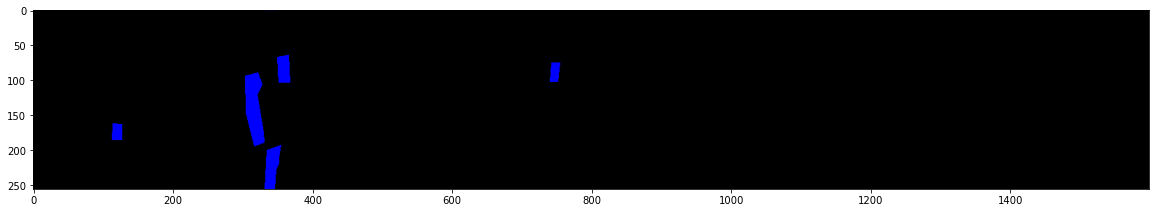

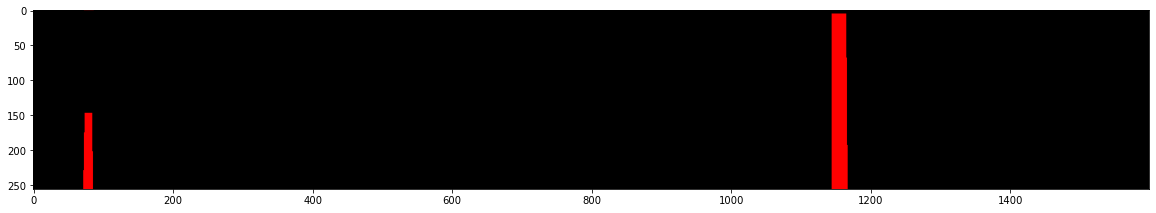

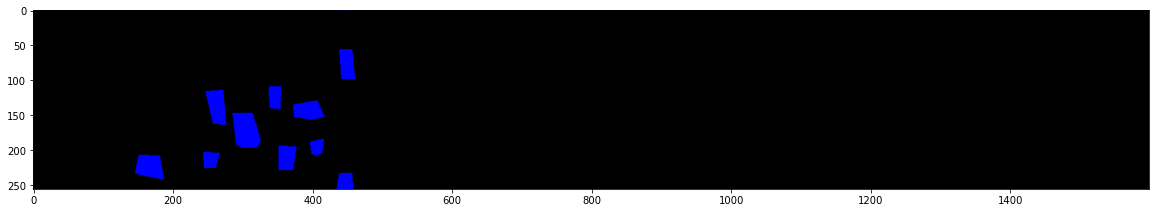

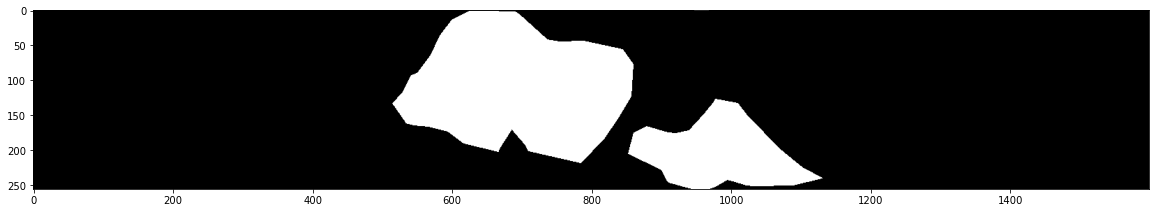

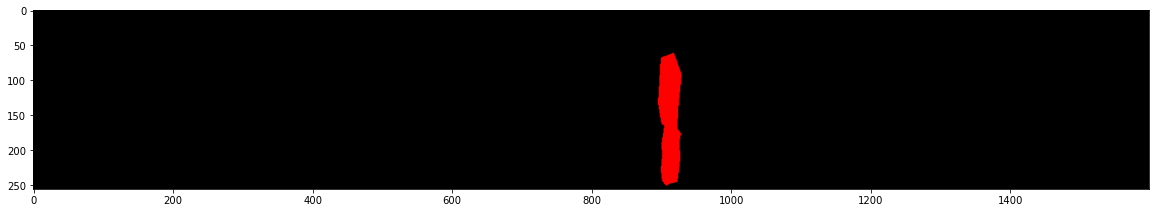

In [29]:
cant = 5
n = 0
for image in sorted(os.listdir(y_train_dir)):
    if n < cant:
        n = n + 1
        plt.figure(figsize=(20, 5))
        img_prueba = cv.cvtColor(cv.imread(os.path.join(y_train_dir, image)), cv.COLOR_BGR2RGB)
        print(img_prueba.shape)
        plt.imshow(img_prueba)
    else:
        break

#### Resumen

Este script auxiliar sirve para convertir los encoded pixels de las etiquetas (.csv) en imágenes .png (mask). 